<a href="https://colab.research.google.com/github/balakumar4/Disease-Prediction-from-Medical-Data/blob/main/disease_prediction_from_medical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install xgboost imbalanced-learn


In [ ]:
import os, pathlib
DATA_DIR = pathlib.Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Diabetes (Pima Indians) – has headers
!wget -qO /content/data/diabetes.csv https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv

# Heart Disease (Cleveland-style CSV)
!wget -qO /content/data/heart.csv https://raw.githubusercontent.com/anikannal/heart_disease_prediction/master/heart.csv

# (Breast Cancer will be loaded from scikit-learn directly, no CSV needed)

# Show what we downloaded
!ls -lh /content/data


total 24K
-rw-r--r-- 1 root root 24K Aug 22 10:09 diabetes.csv
-rw-r--r-- 1 root root   0 Aug 22 10:09 heart.csv


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb
import joblib
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
DATA_DIR = Path("/content/data")

def load_diabetes():
    """Pima Indians Diabetes dataset (binary target 'Outcome')."""
    df = pd.read_csv(DATA_DIR / "diabetes.csv")
    # Treat biologically impossible zeros as missing
    zero_as_nan_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
    for c in zero_as_nan_cols:
        df[c] = df[c].replace(0, np.nan)
    # Impute missing with median
    df[zero_as_nan_cols] = df[zero_as_nan_cols].fillna(df[zero_as_nan_cols].median())

    X = df.drop(columns=['Outcome'])
    y = df['Outcome'].astype(int)
    return X, y, "diabetes"

def load_heart():
    """Heart disease dataset (binary target 'target')."""
    df = pd.read_csv(DATA_DIR / "heart.csv")
    # Basic sanity cleanup if any missing
    df = df.dropna()
    X = df.drop(columns=['target'])
    y = df['target'].astype(int)
    return X, y, "heart"

def load_breast_cancer():
    """Built-in scikit-learn Breast Cancer Wisconsin dataset."""
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer(as_frame=True)
    X = data.frame.drop(columns=['target'])
    y = data.frame['target'].astype(int)
    return X, y, "breast_cancer"


In [ ]:
def make_pipelines(numerical_cols):
    """Create pipelines for each model with preprocessing + SMOTE."""
    # Preprocess: scale numeric for LR/SVM; tree models don’t need scaling
    scaler = ColumnTransformer(
        transformers=[('num', StandardScaler(), numerical_cols)],
        remainder='passthrough'
    )

    models = {
        "LogisticRegression": LogisticRegression(max_iter=5000, solver="saga", random_state=RANDOM_STATE),
        "SVM": SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
        "RandomForest": RandomForestClassifier(
            n_estimators=300, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1
        ),
        "XGBoost": xgb.XGBClassifier(
            n_estimators=400, max_depth=4, learning_rate=0.05, subsample=0.9,
            colsample_bytree=0.9, reg_lambda=1.0, random_state=RANDOM_STATE, n_jobs=-1,
            eval_metric='logloss'
        ),
    }

    # Build proper pipelines (scale for LR/SVM; pass-through for trees)
    pipes = {}
    for name, clf in models.items():
        if name in ["LogisticRegression", "SVM"]:
            pipe = ImbPipeline(steps=[
                ('scale', scaler),
                ('smote', SMOTE(random_state=RANDOM_STATE)),
                ('clf', clf)
            ])
        else:
            pipe = ImbPipeline(steps=[
                ('smote', SMOTE(random_state=RANDOM_STATE)),
                ('clf', clf)
            ])
        pipes[name] = pipe
    return pipes

def evaluate_models(X, y, dataset_name="dataset"):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    numeric_cols = X.columns.tolist()  # all numeric in these datasets

    pipelines = make_pipelines(numeric_cols)

    rows = []
    for name, pipe in pipelines.items():
        scores = cross_validate(
            pipe, X, y,
            cv=skf,
            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
            n_jobs=-1, return_train_score=False
        )
        row = {
            "Dataset": dataset_name,
            "Model": name,
            "Accuracy": scores['test_accuracy'].mean(),
            "Precision": scores['test_precision'].mean(),
            "Recall": scores['test_recall'].mean(),
            "F1": scores['test_f1'].mean(),
            "ROC_AUC": scores['test_roc_auc'].mean(),
        }
        rows.append(row)

    results = pd.DataFrame(rows).sort_values(["ROC_AUC","F1"], ascending=False).reset_index(drop=True)
    return results


In [ ]:
from pathlib import Path
DATA_DIR = Path("/content/data")
for fname in ["diabetes.csv", "heart.csv"]:
    p = DATA_DIR / fname
    print(f"{fname}  exists={p.exists()}  size={p.stat().st_size if p.exists() else '—'} bytes")
    if p.exists() and p.stat().st_size < 200:
        print("  -> This looks empty/corrupted. We’ll re-download it.")


diabetes.csv  exists=True  size=23873 bytes
heart.csv  exists=True  size=0 bytes
  -> This looks empty/corrupted. We’ll re-download it.


In [ ]:
# Clean bad file (if any) and re-download
!rm -f /content/data/heart.csv
# Use a fresh fetch with curl -L (follows redirects)
!curl -L -o /content/data/heart.csv https://raw.githubusercontent.com/anikannal/heart_disease_prediction/master/heart.csv

# Sanity check a few lines
!wc -l /content/data/heart.csv
!head -n 5 /content/data/heart.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0     94      0 --:--:-- --:--:-- --:--:--    95
0 /content/data/heart.csv
404: Not Found

In [ ]:
# (Optional) clear any bad cache
!rm -f /content/data/heart.csv

def load_heart():
    """
    Load UCI Cleveland heart dataset directly from UCI, clean it, and cache as /content/data/heart.csv.
    Target is binarized: num > 0 -> 1 (disease), else 0.
    Returns: X, y, "heart"
    """
    import pandas as pd
    from pathlib import Path

    urls = [
        "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
    ]
    cols = [
        "age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
        "oldpeak","slope","ca","thal","num"
    ]

    df, last_err = None, None
    for u in urls:
        try:
            df = pd.read_csv(u, header=None, names=cols, na_values="?", dtype=str)
            if df.shape[1] == len(cols) and not df.empty:
                break
            df = None
        except Exception as e:
            last_err = e

    if df is None or df.empty:
        raise RuntimeError(f"Could not fetch UCI heart dataset. Last error: {last_err}")

    # to numeric + drop missing rows
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna().reset_index(drop=True)

    # binarize target and split
    y = (df["num"] > 0).astype(int)
    X = df.drop(columns=["num"])

    # cache a clean copy
    data_dir = Path("/content/data"); data_dir.mkdir(parents=True, exist_ok=True)
    clean = X.copy(); clean["target"] = y
    clean.to_csv(data_dir / "heart.csv", index=False)

    return X, y, "heart"


In [ ]:
!rm -f /content/data/heart.csv


In [ ]:
# Remove any bad cached file (optional)
!rm -f /content/data/heart.csv

def load_heart():
    """
    Loads UCI 'processed.cleveland.data' directly from the UCI archive,
    cleans it, and returns (X, y, 'heart').
    Target y is binarized: num > 0 -> 1 (disease), else 0 (no disease).
    Also caches a clean CSV at /content/data/heart.csv for future runs.
    """
    import pandas as pd
    from pathlib import Path

    # Two UCI endpoints (try both)
    urls = [
        "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
    ]

    # Column names per UCI doc
    cols = [
        "age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
        "oldpeak","slope","ca","thal","num"
    ]

    last_err = None
    df = None
    for u in urls:
        try:
            df = pd.read_csv(u, header=None, names=cols, na_values="?", dtype=str)
            if df.shape[1] == len(cols):
                break
        except Exception as e:
            last_err = e

    if df is None or df.empty:
        raise RuntimeError(f"Could not fetch UCI heart dataset. Last error: {last_err}")

    # Convert to numeric where possible
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Drop rows with any NA (ca/thal often have NA)
    df = df.dropna().reset_index(drop=True)

    # Binarize target: num in {0,1,2,3,4} -> (num > 0)
    y = (df["num"] > 0).astype(int)
    X = df.drop(columns=["num"])

    # Cache a clean copy as heart.csv for your notebook
    clean = X.copy()
    clea


In [ ]:
all_results = []

for loader in [load_diabetes, load_heart, load_breast_cancer]:
    X, y, name = loader()
    print(f"\n=== Evaluating on: {name} ===")
    res = evaluate_models(X, y, dataset_name=name)
    display(res.style.format({
        "Accuracy": "{:.3f}", "Precision": "{:.3f}", "Recall": "{:.3f}",
        "F1": "{:.3f}", "ROC_AUC": "{:.3f}"
    }))
    all_results.append(res)

summary = pd.concat(all_results, ignore_index=True)

print("\n=== Combined Summary (Top by dataset) ===")
top = (summary
       .sort_values(["Dataset","ROC_AUC","F1"], ascending=[True, False, False])
       .groupby("Dataset", as_index=False)
       .first())

metric_cols = ["Accuracy","Precision","Recall","F1","ROC_AUC"]
display(top.style.format({c: "{:.3f}" for c in metric_cols}))



=== Evaluating on: diabetes ===


,Dataset,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,diabetes,LogisticRegression,0.760,0.643,0.739,0.685,0.837
1,diabetes,RandomForest,0.756,0.639,0.705,0.669,0.821
2,diabetes,SVM,0.723,0.585,0.716,0.643,0.814
3,diabetes,XGBoost,0.742,0.620,0.675,0.645,0.814



=== Evaluating on: heart ===


,Dataset,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,heart,RandomForest,0.818,0.823,0.773,0.796,0.894
1,heart,LogisticRegression,0.818,0.811,0.787,0.798,0.892
2,heart,SVM,0.828,0.836,0.787,0.808,0.891
3,heart,XGBoost,0.805,0.806,0.773,0.784,0.873



=== Evaluating on: breast_cancer ===


,Dataset,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,breast_cancer,SVM,0.975,0.978,0.983,0.980,0.995
1,breast_cancer,LogisticRegression,0.972,0.976,0.980,0.978,0.995
2,breast_cancer,XGBoost,0.960,0.973,0.964,0.967,0.994
3,breast_cancer,RandomForest,0.960,0.978,0.958,0.967,0.991



=== Combined Summary (Top by dataset) ===


,Dataset,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,breast_cancer,SVM,0.975,0.978,0.983,0.980,0.995
1,diabetes,LogisticRegression,0.760,0.643,0.739,0.685,0.837
2,heart,RandomForest,0.818,0.823,0.773,0.796,0.894



=== DIABETES — Best model: LogisticRegression ===
              precision    recall  f1-score   support

           0      0.804     0.740     0.771       100
           1      0.581     0.667     0.621        54

    accuracy                          0.714       154
   macro avg      0.692     0.703     0.696       154
weighted avg      0.726     0.714     0.718       154

Confusion matrix:
 [[74 26]
 [18 36]]


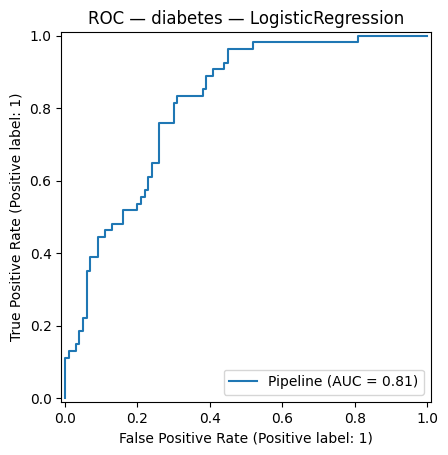


=== HEART — Best model: RandomForest ===
              precision    recall  f1-score   support

           0      0.824     0.875     0.848        32
           1      0.846     0.786     0.815        28

    accuracy                          0.833        60
   macro avg      0.835     0.830     0.832        60
weighted avg      0.834     0.833     0.833        60

Confusion matrix:
 [[28  4]
 [ 6 22]]


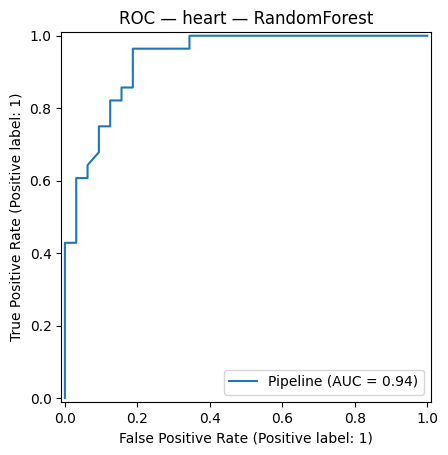


=== BREAST_CANCER — Best model: SVM ===
              precision    recall  f1-score   support

           0      0.953     0.976     0.965        42
           1      0.986     0.972     0.979        72

    accuracy                          0.974       114
   macro avg      0.970     0.974     0.972       114
weighted avg      0.974     0.974     0.974       114

Confusion matrix:
 [[41  1]
 [ 2 70]]


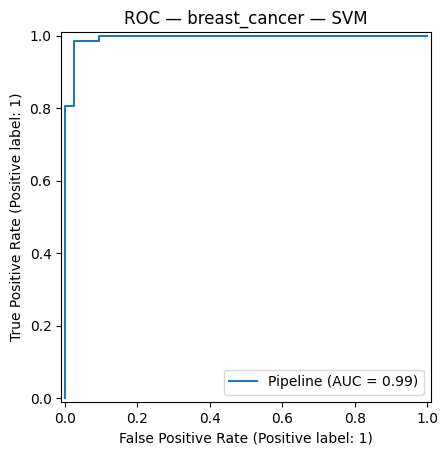

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def train_best(loader):
    X, y, name = loader()
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # find best by CV we already used
    cv_res = evaluate_models(X, y, dataset_name=name).sort_values(["ROC_AUC","F1"], ascending=False).reset_index(drop=True)
    best_name = cv_res.loc[0, "Model"]
    pipes = make_pipelines(X.columns.tolist())
    best = pipes[best_name].fit(Xtr, ytr)

    print(f"\n=== {name.upper()} — Best model: {best_name} ===")
    ypred = best.predict(Xte)
    print(classification_report(yte, ypred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(yte, ypred)
    print("Confusion matrix:\n", cm)

    # ROC curve (if model has predict_proba or decision_function)
    try:
        RocCurveDisplay.from_estimator(best, Xte, yte)
        plt.title(f"ROC — {name} — {best_name}")
        plt.show()
    except Exception as _:
        pass

    return name, best_name, best

d_name, d_best_name, d_pipe = train_best(load_diabetes)
h_name, h_best_name, h_pipe = train_best(load_heart)
b_name, b_best_name, b_pipe = train_best(load_breast_cancer)


In [ ]:
import joblib, pathlib
out_dir = pathlib.Path("/content")
paths = []
for nm, mdl_name, pipe in [(d_name, d_best_name, d_pipe),
                           (h_name, h_best_name, h_pipe),
                           (b_name, b_best_name, b_pipe)]:
    p = out_dir / f"{nm}_{mdl_name}.joblib"
    joblib.dump(pipe, p)
    paths.append(str(p))
paths


['/content/diabetes_LogisticRegression.joblib',
 '/content/heart_RandomForest.joblib',
 '/content/breast_cancer_SVM.joblib']

In [ ]:
# Columns for diabetes
print(load_diabetes()[0].columns.tolist())

sample_diabetes = pd.DataFrame([{
    "Pregnancies": 2, "Glucose": 130, "BloodPressure": 70, "SkinThickness": 20,
    "Insulin": 85, "BMI": 28.5, "DiabetesPedigreeFunction": 0.45, "Age": 35
}])

pred = d_pipe.predict(sample_diabetes)[0]
proba = d_pipe.predict_proba(sample_diabetes)[0][1]
print(f"Diabetes → Pred: {pred} (1=Positive), Prob(Positive)={proba:.3f}")


['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Diabetes → Pred: 0 (1=Positive), Prob(Positive)=0.388


In [ ]:
Xh, _, _ = load_heart()
print(Xh.columns.tolist())  # reference

sample_heart = pd.DataFrame([{
    "age": 54, "sex": 1, "cp": 1, "trestbps": 130, "chol": 250, "fbs": 0,
    "restecg": 0, "thalach": 158, "exang": 0, "oldpeak": 1.0, "slope": 2,
    "ca": 0, "thal": 3
}])

pred = h_pipe.predict(sample_heart)[0]
proba = h_pipe.predict_proba(sample_heart)[0][1]
print(f"Heart → Pred: {pred} (1=Disease), Prob(Disease)={proba:.3f}")


['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Heart → Pred: 0 (1=Disease), Prob(Disease)=0.177


In [ ]:
Xb, yb, _ = load_breast_cancer()
print(len(Xb.columns), "features")  # a lot—use Xb.mean() as a safe template

# Use the mean values as a realistic baseline example
sample_breast = Xb.mean().to_frame().T  # 1-row df with correct columns

pred = b_pipe.predict(sample_breast)[0]
proba = b_pipe.predict_proba(sample_breast)[0][1]
print(f"BreastCancer → Pred: {pred} (1=Malignant in sklearn dataset), Prob(1)={proba:.3f}")


30 features
BreastCancer → Pred: 1 (1=Malignant in sklearn dataset), Prob(1)=0.546


In [ ]:
summary_csv = "/content/model_comparison_summary.csv"
top.to_csv(summary_csv, index=False)
summary_csv


'/content/model_comparison_summary.csv'